In [240]:
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [217]:
data = pd.read_csv('sales_summary.csv')

In [218]:
# dropdown choice : profit_2020, sales_2020
choice = 'profit_2020'  
target = 'sales_target' if choice == 'sales_2020' else 'profit_target'

# Creation des KPI

In [219]:
# Dropdown choix du mois : 'Janvier', Février, 'Mars', 'None'
month = 'Mars'
# month = None

def get_progress(df, col1=choice):
    return int((df[col1].sum() / df[target].sum()) * 100)

# def compare_to_target(df, col1):
#     return get_progress(df, col1) - 100 


if month:
    df = data.loc[data['Month'] == month]
    revenue = df['sales_2020'].sum()
#     revenue_rate = compare_to_target(df, 'sales_2020')
    profit = df['profit_2020'].sum()
#     profit_rate = compare_to_target(df, 'profit_2020')
    progress = get_progress(df) 
else:
    revenue = data['sales_2020'].sum()
#     revenue_rate = compare_to_target(data, 'sales_2020')
    profit = data['profit_2020'].sum()
    profit_rate = compare_to_target(data, 'profit_2020')
#     progress = get_progress(data) 
    
print(revenue, profit, progress,profit_rate)

3006303.227245993 240504.25817967943 93 0


# Bar Chart par ville

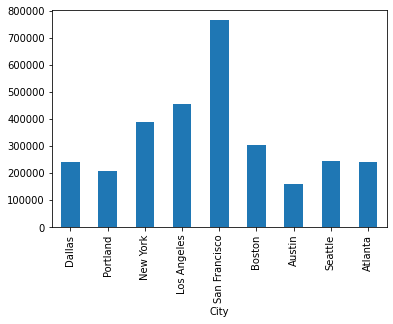

In [233]:
month = 'Mars'
# month = None

if month:
    df = data.loc[data['Month'] == month].set_index('City')
    display(df['sales_2020'].plot.bar())
else:
    df = data.groupby('City').sum()
    display(df['sales_2020'].plot.bar())


In [237]:
df = data.loc[data['Month'] == month].set_index('City')
df

,Month,sales_2019,sales_target,sales_2020,profit_target,profit_2020
City,,,,,,
Dallas,Mars,222376.678921,255733.180759,240389.189913,20458.654461,19231.135193
Portland,Mars,187208.009117,215289.210484,206677.642065,17223.136839,16534.211365
New York,Mars,367262.198232,422351.527967,388563.405730,33788.122237,31085.072458
Los Angeles,Mars,429929.367867,494418.773048,454865.271204,39553.501844,36389.221696
San Francisco,Mars,693726.956571,797786.000056,765874.560054,63822.880005,61269.964804
Boston,Mars,301023.808378,346177.379635,304636.094079,27694.190371,24370.887526
Austin,Mars,154549.269222,177731.659605,158181.177048,14218.532768,12654.494164
Seattle,Mars,219118.698544,251986.503326,244426.908226,20158.920266,19554.152658
Atlanta,Mars,231905.378812,266691.185634,242688.978927,21335.294851,19415.118314


In [252]:
fig = go.Figure([
    go.Scatter(name='Target', x=df.index, y=df['sales_target'], mode = 'markers'),
    go.Bar(name='Sales', x=df.index, y=df['sales_2020'])
])

fig.update_layout(barmode='overlay')